In [1]:
#Comparing Sources in a few different FermiLAT Catalogs

In [1]:
import astropy.io.fits as fits
import astropy as ap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_venn as mpv

In [2]:
#Open fits files
fle1 = fits.open('./1fle.fits')
fhl3 = fits.open('./3fhl.fit')
fgl3 = fits.open('./3fgl.fit')

In [3]:
#fle1.info()
#fhl3.info()
#fgl3.info()

In [4]:
#Get catalogs
catList_1fle = fle1[1]
catList_3fhl = fhl3[1]
catList_3fgl = fgl3[1]

In [5]:
#print(catList_1fle.columns[:])
#print(catList_3fhl.columns[:])
#print(catList_3fgl.columns[:])

In [6]:
#Get important data columns into arrays
data_1fle = catList_1fle.data
name_1fle = np.array(data_1fle.field('Name'))
name3fgl_1fle = np.array(data_1fle.field('Assoc3FGL'))
class_1fle = np.array(data_1fle.field('Class1'))
flux30_100_1fle = np.array(data_1fle.field('EF30-100'))
ph_flux30_100_1fle = np.array(data_1fle.field('F30-100'))

data_3fgl = catList_3fgl.data
name_3fgl = np.array(data_3fgl.field('Source_Name'))
class_3fgl = np.array(data_3fgl.field('CLASS1'))
name2fgl_3fgl = np.array(data_3fgl.field('2FGL_Name'))

In [7]:
#Make dataframes with relevant data columns

df_3fgl = pd.DataFrame(name_3fgl)
df_3fgl.columns = ['Name_3FGL']
df_3fgl['Class_3FGL'] = class_3fgl
df_3fgl['Name_2FGL'] = name2fgl_3fgl
fgl3.close()

In [8]:
#replace non 3fgl associations with separate values for 1fle
#This is to avoid merging dataframes on NaN values
for i in range(len(name3fgl_1fle)):
    if '3FGL' not in name3fgl_1fle[i]:
        name3fgl_1fle[i] = False
        #print(name3fgl_3fhl[i])
        
df_1fle = pd.DataFrame(name_1fle)
df_1fle.columns = ['Name_1FLE']
df_1fle['Class_1FLE'] = class_1fle
df_1fle['Name_3FGL'] = name3fgl_1fle
df_1fle['MeVFlux_1FLE'] = flux30_100_1fle
df_1fle['MeVPhoFlux_1FLE'] = ph_flux30_100_1fle
fle1.close()

In [ ]:


#----------------------------
#COMPARISON WITH 3FHL CATALOG
#----------------------------



In [ ]:
print('Doing 3FHL Comparison...')

In [10]:
data_3fhl = catList_3fhl.data
name_3fhl = np.array(data_3fhl.field('Source_Name'))
name3fgl_3fhl = np.array(data_3fhl.field('ASSOC_GAM'))
class_3fhl = np.array(data_3fhl.field('CLASS'))
fluxTotal_3fhl = np.array(data_3fhl.field('Energy_Flux')).byteswap().newbyteorder() #erg/cm^2/s

ph_fluxTotal_3fhl = np.array(data_3fhl.field('Flux')) #/cm^2/s
pivE_3fhl = np.array(data_3fhl.field('Pivot_Energy')) #GeV
specI_3fhl = np.array(data_3fhl.field('Spectral_Index')) 
fluxD_3fhl = np.array(data_3fhl.field('Flux_Density')) #/cm^2/GeV/s
specType_3fhl = np.array(data_3fhl.field('SpectrumType')) 

#replace non 3fgl associations with separate values for 3fhl
#This is to avoid merging dataframes on NaN values

for i in range(len(name3fgl_3fhl)):
    if '3FGL' not in name3fgl_3fhl[i]:
        name3fgl_3fhl[i] = None
        #print(name3fgl_3fhl[i])

In [11]:
df_3fhl = pd.DataFrame(name_3fhl)
df_3fhl.columns = ['Name_3FHL']
df_3fhl['Class_3FHL'] = class_3fhl
df_3fhl['Name_3FGL'] = name3fgl_3fhl
df_3fhl['IntFlux_10Gto1T'] = fluxTotal_3fhl
df_3fhl['IntPhoFlux_10Gto1T'] = ph_fluxTotal_3fhl
fhl3.close()

In [33]:
print(fluxTotal_3fhl[1], ph_fluxTotal_3fhl[1], pivE_3fhl[1], specI_3fhl[1], fluxD_3fhl[1], specType_3fhl[1])

3.490008e-12 4.323026e-11 28.423996 1.7818612 5.425346e-13 PowerLaw   


In [31]:
ph_fluxTotal_3fhl[1] * np.log(100) * -specI_3fhl[1]

-3.547377410567373e-10

In [22]:
u = ap.units
w = 4.362e-17 * u.m
a = 4.323026e-11 * (u.photon / u.cm**2 / u.s)
b = a.to(u.erg / u.cm**2 / u.s, u.spectral_density(w))
print(b)

1.968697177452339e-12 erg / (cm2 s)


In [ ]:
#Merge 1fle and 3fhl on shared 3fgl names

df_1fle_3fhl = pd.merge(df_3fhl, df_1fle, on='Name_3FGL', how='inner')

overlap_class_list = np.array(df_1fle_3fhl['Class_1FLE'])
unique, counts = np.unique(overlap_class_list, return_counts=True)
overlap_class_dict = dict(zip(unique, counts))
print('The following are the number of each class that is included in the overlapped sources.')
print(overlap_class_dict)

In [ ]:
print('The 3FHL Catalog seems to have two double counted sources--ones that share a 3FGL association.')
print('These sources are not double counted in the 1FLE catalog, but will be in this comparison.')
print(df_1fle_3fhl.loc[(df_1fle_3fhl.loc[:,'Name_3FGL'] == '3FGL J1801.3-2326e') | (df_1fle_3fhl.loc[:,'Name_3FGL'] == '3FGL J1633.0-4746e')])

In [ ]:
#Get and plot integral fluxes of the overlapped sources
#And compare to hist of full 3fhl source fluxes

flux_overlap132 = df_1fle_3fhl['IntFlux_10Gto1T'].to_numpy()
MeVFlux_overlap = df_1fle_3fhl['MeVFlux_1FLE'].to_numpy()
print(np.min(flux_overlap132), np.max(flux_overlap132))
print(np.min(fluxTotal_3fhl), np.max(fluxTotal_3fhl))

In [ ]:
#HE Histogram
fig, ax1 = plt.subplots(facecolor='w', figsize=(8,6))

logbins = np.logspace(np.log10(1.0e-13),np.log10(1.0e-9), 25)
ax1.hist(fluxTotal_3fhl, bins=logbins, alpha=1, color='r', label='3FHL', histtype='step', linestyle='-')
ax1.hist(flux_overlap132, bins=logbins, alpha=1, color='r', label='Shared', histtype='step', linestyle='--')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Counts')
ax1.set_xlabel('Integrated Flux (10GeV-1TeV) [erg/cm^2/s]', color='r')
ax1.tick_params(axis='x', labelcolor='r')

#ax2 = ax1.twiny()

#logbins = np.logspace(np.log10(6.0e-8),np.log10(1.0e-4), 25)
#ax2.hist(flux30_100_1fle, bins=logbins, alpha=1, color='b', label='1FLE', histtype='step', linestyle='-')

#ax2.set_xscale('log')
#ax2.set_yscale('log')
#ax2.set_ylabel('Counts')
#ax2.set_xlabel('Integrated Photon Flux (30-100 MeV) [1/cm^2/s]', color='b')
#ax2.tick_params(axis='x', labelcolor='b')

plt.legend(loc='best')
plt.savefig('./plots/HE_FluxPDF_3FHL_wOverlap.png')
plt.close()


In [ ]:
#Flux weight scatter
fig, ax = plt.subplots(facecolor='w', figsize=(6,6))
ax.scatter(MeVFlux_overlap/np.sum(flux30_100_1fle), flux_overlap132/np.sum(fluxTotal_3fhl), marker='+', color='purple')
ax.set_xlabel('1FLE Normalized Flux (30-100 MeV)', color='b')
ax.set_ylabel('3FHL Normalized Flux (10 GeV-100 TeV)', color='r')
#plt.xlim(-0.001,.2)
#plt.ylim(-0.001,.2)

lim = .00001, 1
ax.plot(lim, lim, 'k--', zorder=-10)
ax.set(xlim=lim, ylim=lim, aspect='equal')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('Normalized Fluxes of 1FLE/3FHL Shared Sources')
plt.savefig('./plots/NormFlux_OverlapComparison_3FHL.png')
plt.close()


In [ ]:
#Venn Diagram
plt.figure(facecolor='w', figsize=(6,6))
plt.title('3FGL Associated Sources')
mpv.venn2([set(name3fgl_1fle),set(name3fgl_3fhl)], set_labels=('1FLE', '3FHL'), set_colors=('b','r'))
plt.savefig('./plots/VennOverlap_3FHL.png')
plt.close()

In [ ]:
print('Done 3FHL Comparison...')

In [ ]:


#----------------------------
#COMPARISON WITH 2LAC CATALOG
#----------------------------



In [ ]:
print('Doing 2LAC Comparison...')

In [42]:
#Get 2FGL catalog that Thorsten used for 2LAC E Fluxes
thorst = fits.open('./fermi_2year_ps_catalogue_official.fits')
catList_thorst = thorst[1]
data_thorst = catList_thorst.data
name_thorst = np.array(data_thorst.field('Source_Name'))
EFlux_thorst = np.array(data_thorst.field('Energy_Flux100')).byteswap().newbyteorder()


In [44]:
#Make into DF
df_2fgl = pd.DataFrame(name_thorst)
df_2fgl.columns = ['Name_2FGL']
df_2fgl['GeVFlux_2FGL'] = EFlux_thorst
thorst.close()


In [45]:
#Read 2LAC into Dataframe
import csv
df_2lac = pd.read_table('./2lac.txt', sep='|')


In [46]:
#Rename Columns
df_2lac.columns = ["id","Name_2FGL","RA","DEC","THETA","Class_2LAC", "Redshift", "SED", "GeVPhoFlux_2LAC", "Spectral_Ind"]



In [47]:
#Get rid of whitespace so naming conventions match
df_2lac['Name_2FGL'] = df_2lac['Name_2FGL'].apply(lambda x: x.replace(' ',''))
df_2fgl['Name_2FGL'] = df_2fgl['Name_2FGL'].apply(lambda x: x.replace(' ',''))
df_3fgl['Name_2FGL'] = df_3fgl['Name_2FGL'].apply(lambda x: x.replace(' ',''))


In [49]:
#Keeping only the columns of current interest
df_2lac = df_2lac[['Name_2FGL', 'Class_2LAC']]

#Change dtype of GeVFlux to float and set the three values with fluxes as max limits to that limit
#df_2lac['GeVPhoFlux_2LAC'] = df_2lac['GeVPhoFlux_2LAC'].apply(lambda x: float(x.replace('<','').strip()))


In [50]:
#First, merge 1fle and 3fgl on shared 3fgl name
df_1fle_3fgl = pd.merge(df_3fgl, df_1fle, on='Name_3FGL', how='inner')


In [51]:
#Now merge 2LAC and 2FGL (thorst)
df_2lac_2fgl = pd.merge(df_2lac, df_2fgl, on='Name_2FGL', how='inner')


In [52]:
#Then, merge the two merged DFs
df_1fle_3fgl_2lac_2fgl = pd.merge(df_1fle_3fgl, df_2lac_2fgl, on='Name_2FGL', how='inner')


In [53]:
#Keep only columns of current interest
df_1fle_3fgl_2lac_2fgl = df_1fle_3fgl_2lac_2fgl[['Name_3FGL', 'Name_2FGL', 'Name_1FLE', 'Class_1FLE', 'GeVFlux_2FGL', 'MeVFlux_1FLE']]

#134 overlapped sources (see below about duplicate)


In [54]:
#Get overlapped classes
overlap_class_list = np.array(df_1fle_3fgl_2lac_2fgl['Class_1FLE'])
unique, counts = np.unique(overlap_class_list, return_counts=True)
overlap_class_dict = dict(zip(unique, counts))
print('The following are the number of each class that is included in the overlapped sources.')
print(overlap_class_dict)
#29 BLL, 93 FSRQ overlap --> 122 Blazars


The following are the number of each class that is included in the overlapped sources.
{'bcu  ': 8, 'bll  ': 29, 'fsrq ': 93, 'nlsy1': 1, 'rdg  ': 2, 'ssrq ': 1}


In [55]:
#Check for multiple occurrences of counterparts
print('Duplicate Entries:')
ns, cs = np.unique(df_1fle_3fgl_2lac_2fgl['Name_2FGL'], return_counts=True)

rep_dict = dict(zip(ns,cs))

for k in rep_dict.keys():
    if rep_dict[k] != 1:
        print(k,' | ', rep_dict[k])

Duplicate Entries:
2FGLJ1153.2+4935  |  2


In [57]:
print('This merging of dataframes created a duplicate entry for a source that exists once in 1FLE and 3FGL, \n but twice in 2LAC... \n (i.e., there is a pair of sources in 2LAC that share a single 2FGL source which is shared by 1FLE (via 3FGL)):')
print(df_1fle_3fgl_2lac_2fgl.loc[((df_1fle_3fgl_2lac_2fgl.loc[:,'Name_2FGL'] == '2FGLJ1153.2+4935'))])
#29 BLL, 93 (-1 = 92 from duplicate) FSRQ overlap --> 122 (-1 = 121) Blazars


This merging of dataframes created a duplicate entry for a source that exists once in 1FLE and 3FGL, 
 but twice in 2LAC... 
 (i.e., there is a pair of sources in 2LAC that share a single 2FGL source which is shared by 1FLE (via 3FGL)):
             Name_3FGL         Name_2FGL        Name_1FLE Class_1FLE  \
66  3FGL J1153.4+4932   2FGLJ1153.2+4935  1FLE J1147+4836      fsrq    
67  3FGL J1153.4+4932   2FGLJ1153.2+4935  1FLE J1147+4836      fsrq    

    GeVFlux_2FGL  MeVFlux_1FLE  
66  1.163305e-11  7.797230e-12  
67  1.163305e-11  7.797230e-12  


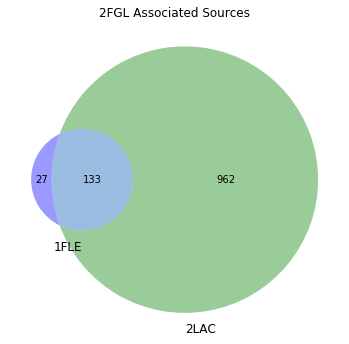

In [58]:
#Overlap Venn Diagram
plt.figure(facecolor='w', figsize=(6,6))
plt.title('2FGL Associated Sources')
mpv.venn2([set(df_1fle_3fgl['Name_2FGL']),set(df_2lac['Name_2FGL'])], set_labels=('1FLE', '2LAC'), set_colors=('b','g'))
#plt.savefig('./plots/VennOverlap_2LAC.png')
plt.show()
plt.close()


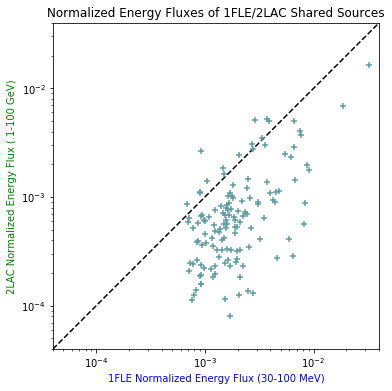

In [66]:
#Flux weight scatter
fig, ax = plt.subplots(facecolor='w', figsize=(6,6))
ax.scatter(df_1fle_3fgl_2lac_2fgl['MeVFlux_1FLE']/np.sum(flux30_100_1fle), df_1fle_3fgl_2lac_2fgl['GeVFlux_2FGL']/np.sum(df_2fgl['GeVFlux_2FGL']), marker='+', color='cadetblue')
ax.set_xlabel('1FLE Normalized Energy Flux (30-100 MeV)', color='b')
ax.set_ylabel('2LAC Normalized Energy Flux (.1-100 GeV)', color='g')
#plt.xlim(-0.001,.2)
#plt.ylim(-0.001,.2)

lim = .00004, .04
ax.plot(lim, lim, 'k--', zorder=-10)
ax.set(xlim=lim, ylim=lim, aspect='equal')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('Normalized Energy Fluxes of 1FLE/2LAC Shared Sources')
plt.savefig('./plots/NormFlux_OverlapComparison_2LAC.png')
plt.show()
plt.close()

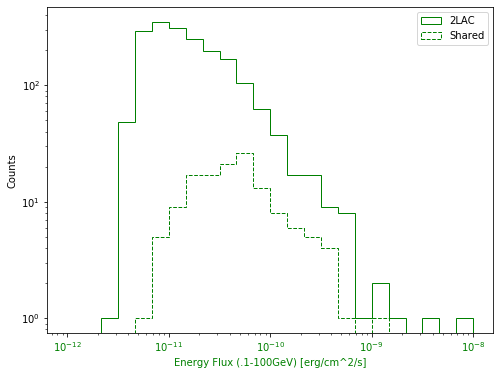

In [67]:
#2LAC Flux Hist
fig, ax1 = plt.subplots(facecolor='w', figsize=(8,6))

logbins = np.logspace(np.log10(1.0e-12),np.log10(1.0e-8), 25)
ax1.hist(df_2fgl['GeVFlux_2FGL'], bins=logbins, alpha=1, color='g', label='2LAC', histtype='step', linestyle='-')
ax1.hist(df_1fle_3fgl_2lac_2fgl['GeVFlux_2FGL'], bins=logbins, alpha=1, color='g', label='Shared', histtype='step', linestyle='--')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy Flux (.1-100GeV) [erg/cm^2/s]', color='g')
ax1.tick_params(axis='x', labelcolor='g')

plt.legend()
plt.savefig('./plots/HE_FluxPDF_2LAC_wOverlap.png')
plt.show()